In [1]:
model_names = ['Original_Pretrained_R2plus1D_18_MotionNet.pth', 
               'dropout_v3_0_10_R2plus1D_18_MotionNet.pth'
              ]

In [2]:
%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset

from src.misc import load_model_by_name


# for finding lv seg borders
import cv2 as cv


# from src.visualization_utils import categorical_dice
%matplotlib widget
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)

In [3]:
def strain_value(l_0, l_i):
    '''
    inputs: l_0, l_i -- original length and new length at some time point, respectively
    output: e -- strain value (positive for elongation, negative for compressing/shortening) as a percentage (e.g. output 0.155 == 15.5 %)
    
    examples: 
        l_i = 10
        l_0 = 5
        e == (10 - 5) / 5 = 1, factor of lengthening relative to original value
        
        l_i = 5
        l_0 = 5
        e == (5 - 5) / 5 = 0, no strain
    '''
    return (l_i - l_0) / l_0

In [4]:
def rmse(x, y):
    ''' return root mean square error difference between the two values passed in'''
    return np.sqrt((x - y) ** 2)

In [5]:
def fromSegOutToEDESLVMasksAndBorders(all_segmentation_outputs, es_index, ed_index, model_num = 0):
    '''
    input: all_segmentation_outputs -- the segmentation outputs from the model wrapped in a list of len number of models that we have
    output: [[ed lv seg, es lv seg], [ed lv seg border, es lv seg border]] all will be 112 x 112 images which pixels of value 0 or 255
    '''
    
    # how many frames ahead is the ES frame relative to the ED frame?
    delta_ed_es_frames = es_index - ed_index

    
    clip_to_grab_index = -1   # grab the last clip where ED frame is the first frame
    # model_num = model_num     # which model's output to grab (0 if just using 1 model)
    clip_with_ed_frame_index_0 = all_segmentation_outputs[model_num][clip_to_grab_index] 

    foo = np.argmax(clip_with_ed_frame_index_0, axis=0)
    foo_times_255 = 255 * foo

    ed_lv_seg = foo_times_255[0]
    es_lv_seg = foo_times_255[delta_ed_es_frames]
    
    
    image_8bit = np.uint8(foo_times_255)
    ed_im = image_8bit[0]
    es_im = image_8bit[delta_ed_es_frames]

    
    ret, thresh = cv.threshold(ed_im, 127, 255, 0)
    ed_contours, ed_hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    ret, thresh = cv.threshold(es_im, 127, 255, 0)
    es_contours, es_hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    
    ed_blank = np.zeros((112,112))
    cv.drawContours(ed_blank, ed_contours, -1, (255,255,255), 1)

    es_blank = np.zeros((112,112))
    cv.drawContours(es_blank, es_contours, -1, (255,255,255), 1)
    
    return [[ed_lv_seg, es_lv_seg], [ed_blank, es_blank]]
    

In [6]:
def groundTruthBoundaries(ed_label, es_label):
    '''
    input: ed_label, es_label -- 112 x 112 manual segmented ed/es lv answers (input values are either 0 or 1)
    output: [[ed label, es label], [ed label border, es label border]]
    '''
    ed_im = np.uint8(ed_label * 255)
    es_im = np.uint8(es_label * 255)

    ret, thresh = cv.threshold(ed_im, 127, 255, 0)
    ed_contours, ed_hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    ret, thresh = cv.threshold(es_im, 127, 255, 0)
    es_contours, es_hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    
    ed_blank = np.zeros((112,112))
    cv.drawContours(ed_blank, ed_contours, -1, (255,255,255), 1)

    es_blank = np.zeros((112,112))
    cv.drawContours(es_blank, es_contours, -1, (255,255,255), 1)

    return [[ed_im, es_im], [ed_blank, es_blank]]

In [7]:
def plotTwoImages(I1, I2, title='title', ax1title='ax1title', ax2title='ax2title'):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    
    ax1.set_title(ax1title)
    ax1.imshow(I1, cmap="gray")
    ax2.set_title(ax2title)
    ax2_img = ax2.imshow(I2, cmap="gray")
    fig.colorbar(ax2_img, ax=ax2)
    
    # fig.show()

In [8]:
batch_size = 4
num_workers = max(4, cpu_count()//2)

def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}


with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", raise_for_es_ed=False, subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)

print(f'test dataset length: {len(test_dataset)}')

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.52it/s]


test dataset length: 1276


In [9]:
def divide_to_consecutive_clips(video, clip_length=32, interpolate_last=False):
    source_video = video.copy()
    video_length = video.shape[1]
    left = video_length % clip_length
    if left != 0 and interpolate_last:
        source_video = torch.Tensor(source_video).unsqueeze(0)
        source_video = F.interpolate(source_video, size=(int(np.round(video_length / clip_length) * clip_length), 112, 112),
                                     mode="trilinear", align_corners=False)
        source_video = source_video.squeeze(0).squeeze(0)
        source_video = source_video.numpy()
    
    videos = np.empty(shape=(1, 3, clip_length, 112, 112))

    for start in range(0, int(clip_length * np.round(video_length / clip_length)), clip_length):
        one_clip = source_video[:, start: start + clip_length]
        one_clip = np.expand_dims(one_clip, 0)
        videos = np.concatenate([videos, one_clip])
    return videos[1:]


def get_all_possible_start_points(ed_index, es_index, video_length, clip_length):
    assert es_index - ed_index > 0, "not a ED to ES clip pair"
    possible_shift = clip_length - (es_index - ed_index)
    allowed_right = video_length - es_index
    if allowed_right < possible_shift:
        return np.arange(ed_index - possible_shift + 1, video_length - clip_length + 1)
    if possible_shift < 0:
        return np.array([ed_index])
    elif ed_index < possible_shift:
        return np.arange(ed_index + 1)
    else:
        return np.arange(ed_index - possible_shift + 1, ed_index + 1)

In [10]:
loaded_in_models = []

for model_name in model_names:
    model_save_path = f"save_models/{model_name}"
    
    model = load_model_by_name(model_name, model_save_path)
    
    loaded_in_models.append((model_name, model))

print(len(loaded_in_models))

/home/wmw015/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/wmw015/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


gpus detected: 4
using cuda
Original_Pretrained_R2plus1D_18_MotionNet.pth has 31575731 parameters.
gpus detected: 4
using cuda
dropout_v3_0_10_R2plus1D_18_MotionNet.pth has 31575731 parameters.
2


In [11]:
test_pat_index = 111  # video index from test dataset

video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]

video.shape

(3, 58, 112, 112)

In [12]:
# get all possible start points (for 32 frame clips)
possible_starts = get_all_possible_start_points(ed_index, es_index, video.shape[1], clip_length=32)

# segment clips by passing thru model, not consecutive 32 frame clips

# segment using all models
all_segmentation_outputs = []
all_motion_outputs = []

# for each model, segment the clips
for name, model in loaded_in_models:
    
    segmentation_outputs = np.empty(shape=(1, 2, 32, 112, 112))
    motion_outputs = np.empty(shape=(1, 4, 32, 112, 112))
    for start in possible_starts:
        one_clip = np.expand_dims(video[:, start: start + 32], 0)
        segmentation_output, motion_output = model(torch.Tensor(one_clip))
        segmentation_outputs = np.concatenate([segmentation_outputs, segmentation_output.cpu().detach().numpy()])
        motion_outputs = np.concatenate([motion_outputs, motion_output.cpu().detach().numpy()])
    segmentation_outputs = segmentation_outputs[1:]
    motion_outputs = motion_outputs[1:]
    
    # save 
    all_segmentation_outputs.append(segmentation_outputs)
    all_motion_outputs.append(motion_outputs)

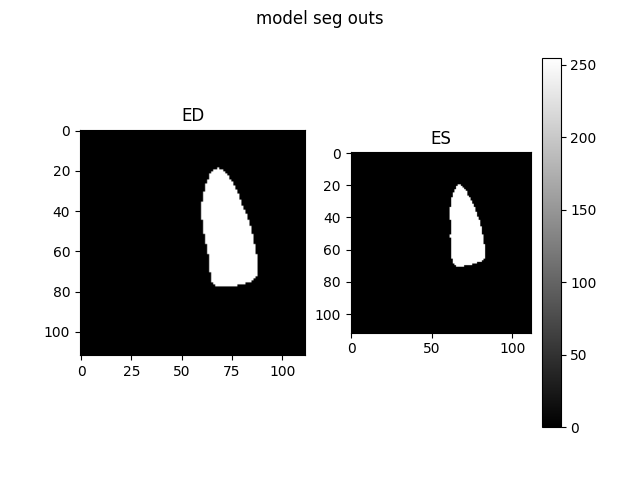

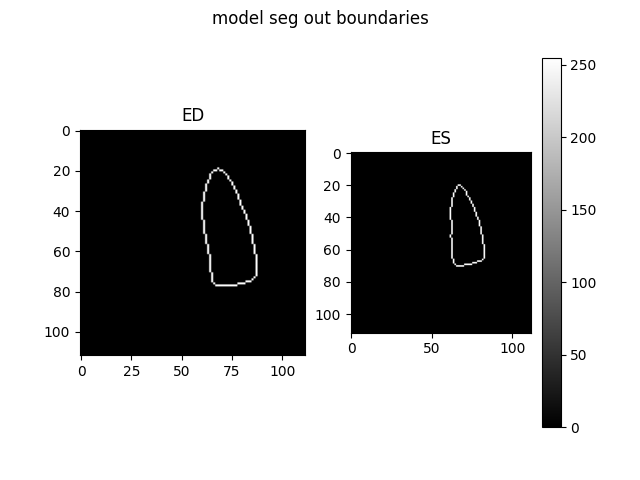

In [13]:
# output: [[ed_lv_seg, es_lv_seg], [ed_blank, es_blank]]
try:
    x = fromSegOutToEDESLVMasksAndBorders(all_segmentation_outputs, es_index, ed_index)
except Exception as e:
    print(e)

plotTwoImages(x[0][0], x[0][1], 'model seg outs', 'ED', 'ES')
plotTwoImages(x[1][0], x[1][1], 'model seg out boundaries', 'ED', 'ES')

In [14]:
es_index, ed_index

(39, 31)

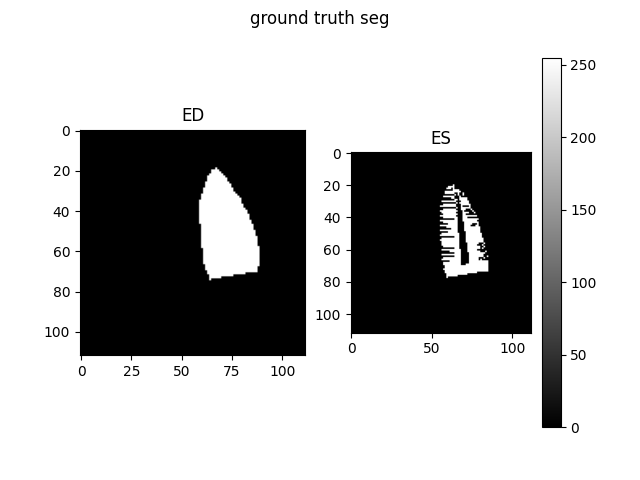

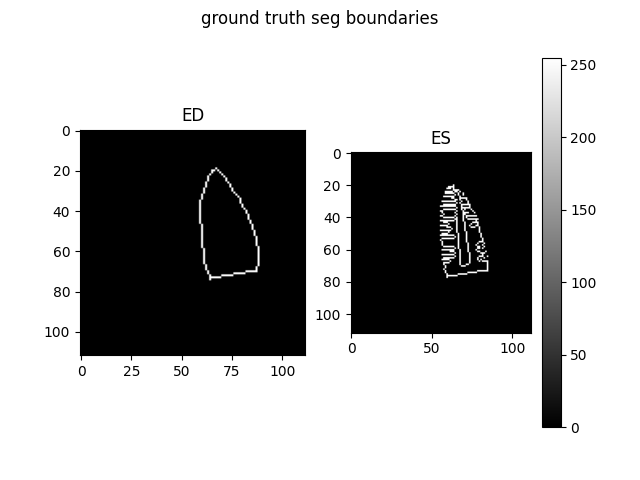

In [15]:
y = groundTruthBoundaries(ed_label, es_label)

plotTwoImages(y[0][0], y[0][1], 'ground truth seg', 'ED', 'ES')
plotTwoImages(y[1][0], y[1][1], 'ground truth seg boundaries', 'ED', 'ES')

In [16]:
# # seg out strain (count pixels of border)
# seg_out_strain = strain_value(np.count_nonzero(x[1][0] == 255), np.count_nonzero(x[1][1] == 255))
                              
# # ground truth strain (count pixels of border)
# ground_truth_strain = strain_value(np.count_nonzero(y[1][0] == 255), np.count_nonzero(y[1][1] == 255))

# print(f'seg_out_strain: {seg_out_strain}, ground_truth_strain: {ground_truth_strain}')
# print(f'RMSE: {rmse(seg_out_strain, ground_truth_strain)}')

In [17]:
for i in range(len(loaded_in_models)):
    x = fromSegOutToEDESLVMasksAndBorders(all_segmentation_outputs, es_index, ed_index, model_num = i)
    print(f'{model_names[i]}')

    seg_out_strain = strain_value(np.count_nonzero(x[1][0] == 255), np.count_nonzero(x[1][1] == 255))
    ground_truth_strain = strain_value(np.count_nonzero(y[1][0] == 255), np.count_nonzero(y[1][1] == 255))

    print(f'seg_out_strain: {seg_out_strain * 100:.2f}%\nground_truth_strain: {ground_truth_strain * 100:.2f}%')
    print(f'RMSE: {rmse(seg_out_strain, ground_truth_strain)}')
    print()

Original_Pretrained_R2plus1D_18_MotionNet.pth
seg_out_strain: -15.04%
ground_truth_strain: 217.69%
RMSE: 2.3272990167727006

dropout_v3_0_10_R2plus1D_18_MotionNet.pth
seg_out_strain: -12.95%
ground_truth_strain: 217.69%
RMSE: 2.3064194798007747

